In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
from pathlib import Path

import keras
import bayesflow as bf
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

INFO:2026-01-31 14:35:40,898:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:bayesflow:Using backend 'jax'
c:\Users\nilsw\OneDrive\Dokumente\GitHub\memilio_abm\pycode\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def likelihood(beta, sigma, N):
    # x: predictor variable
    x = np.random.normal(0, 1, size=N)
    # y: response variable
    y = np.random.normal(beta[0] + beta[1] * x, sigma, size=N)
    return dict(y=y, x=x)

data_draws = likelihood(beta = [2, 1], sigma = 1, N = 3)
print(data_draws["y"].shape)
print(data_draws["y"])

def prior():
    # beta: regression coefficients (intercept, slope)
    beta = np.random.normal([2, 0], [3, 1])
    # sigma: residual standard deviation
    sigma = np.random.gamma(1, 1)
    return dict(beta=beta, sigma=sigma)

prior_draws = prior()
print(prior_draws["beta"].shape)
print(prior_draws["beta"])

def meta():
    # N: number of observation in a dataset
    N = np.random.randint(5, 15)
    return dict(N=N)

meta_draws = meta()
print(meta_draws["N"])

simulator = bf.simulators.make_simulator([prior, likelihood], meta_fn=meta)

(3,)
[ 2.04321023 -0.68774081  1.30299013]
(2,)
[ 5.46992294 -0.63407851]
8


7
(500, 2)
(500, 1)
(500, 7)
(500, 7)
(500, 7, 2)
(500, 1)
(500, 3)


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 105s 474ms/step - loss: 2.5216
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.9624
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.6486
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.4702
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.2912
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.2344
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0694
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0317
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0223
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: -0.0180
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: -0.1891
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: -0.0725
Epoch 13/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: -0.1895
Epoch 14/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: -0.1815
Epoch 15/50
200/200 ━━━━━━━━━━━━━━━

INFO:bayesflow:Training completed in 7.06 minutes.
Sampling: 100%|██████████| 1/1 [00:05<00:00,  5.21s/batch]
INFO:bayesflow:Sampling completed in 5.70 seconds.


(200, 1000, 2)


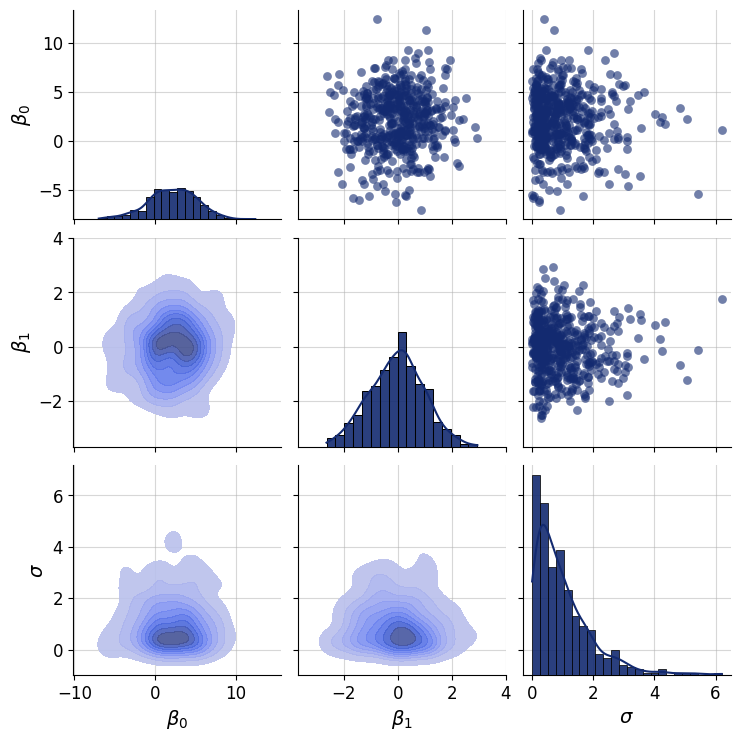

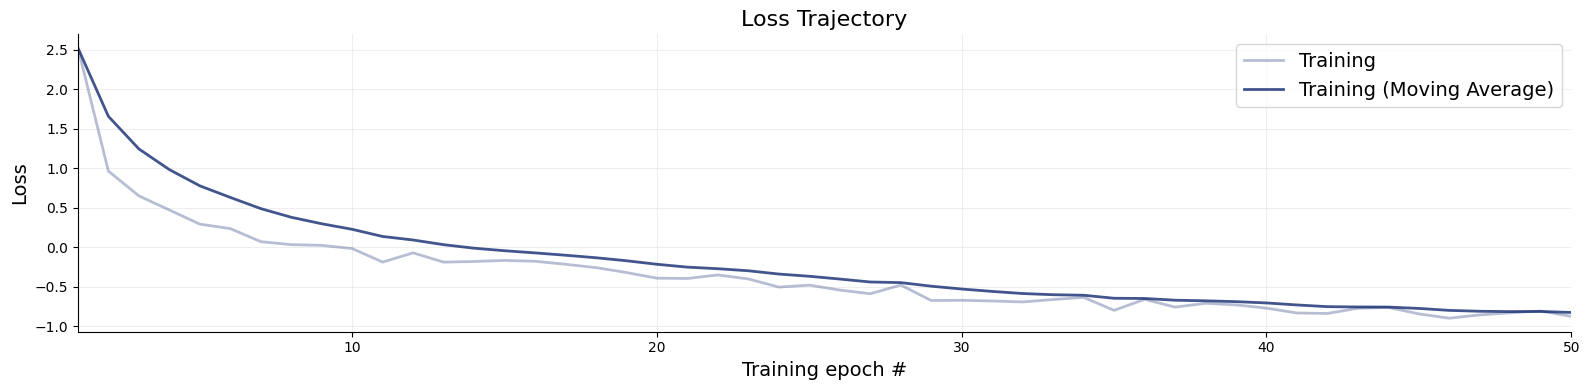

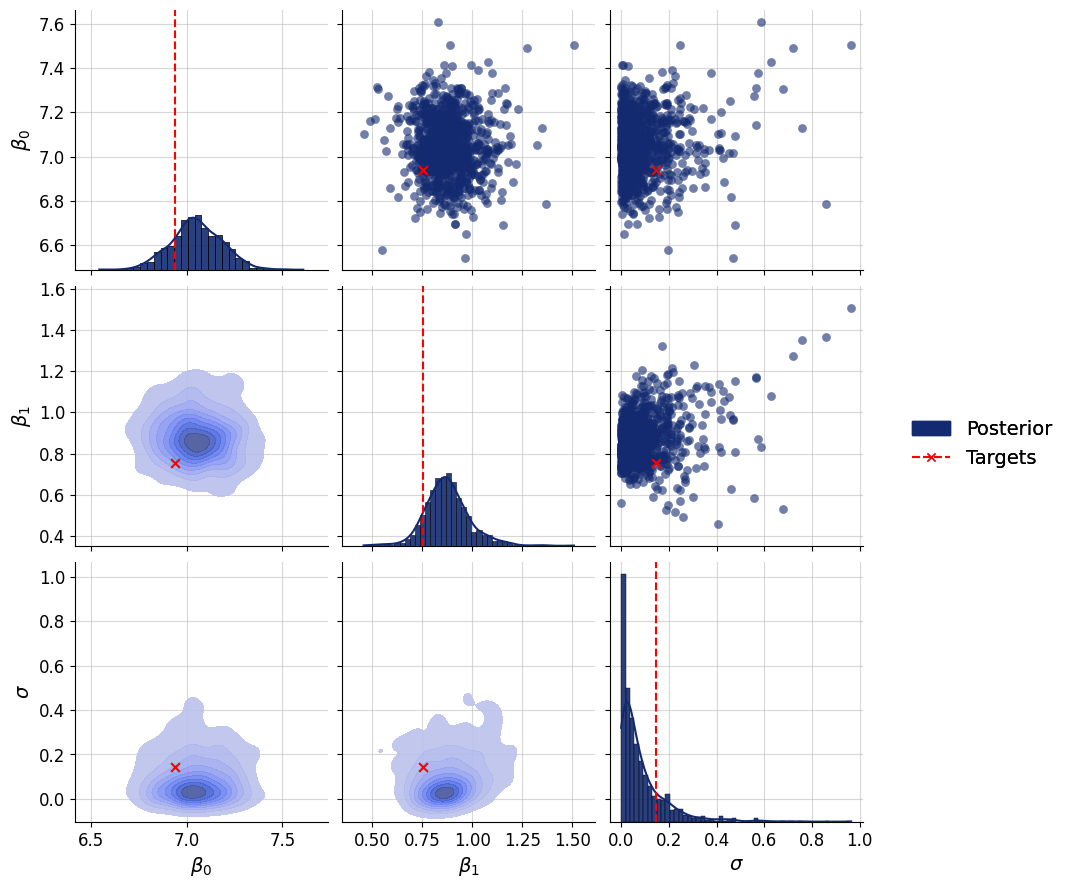

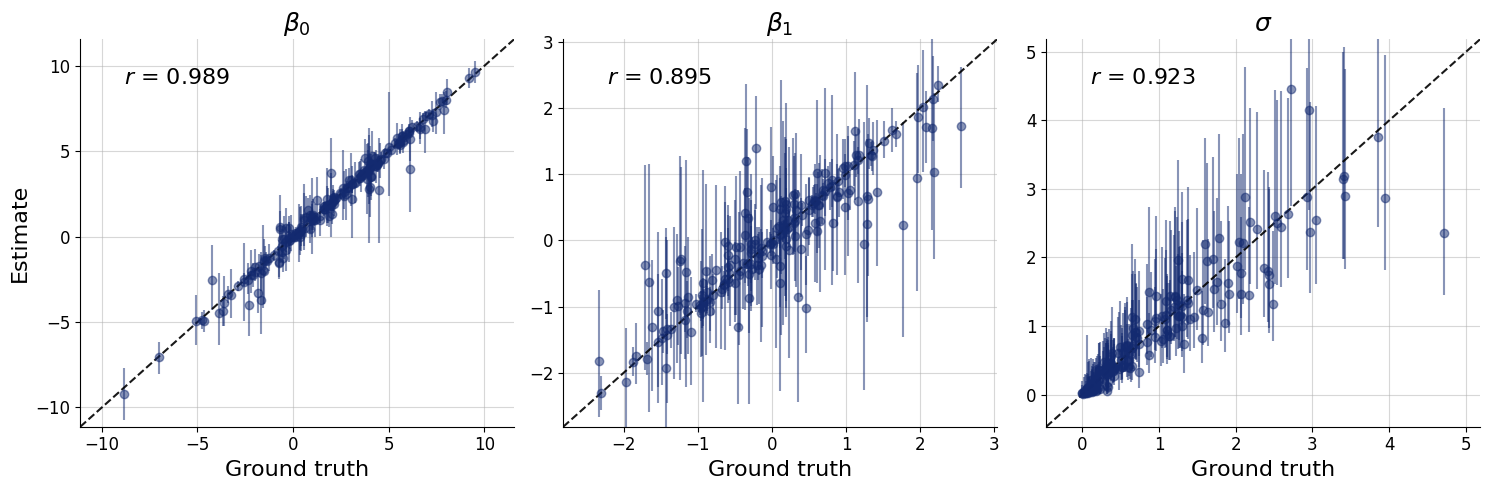

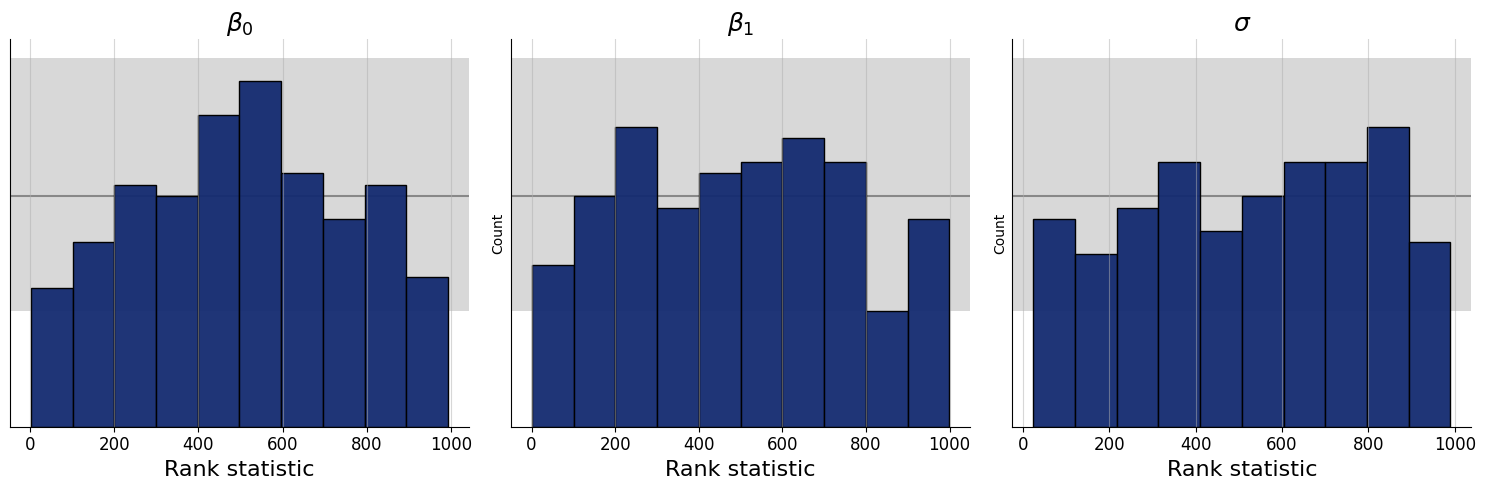

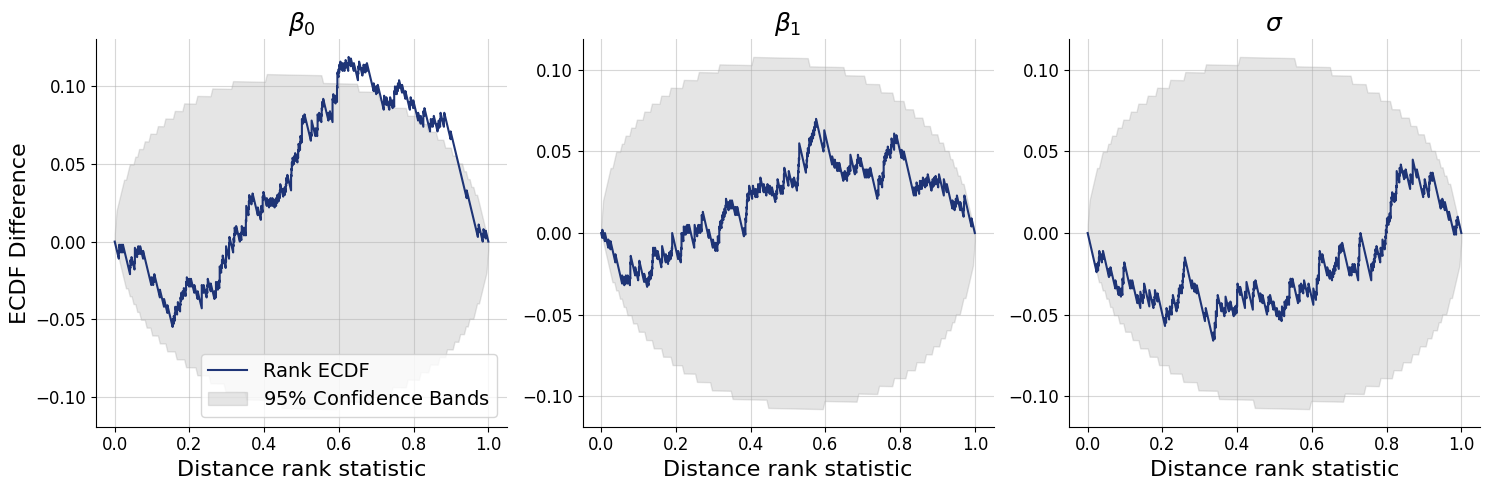

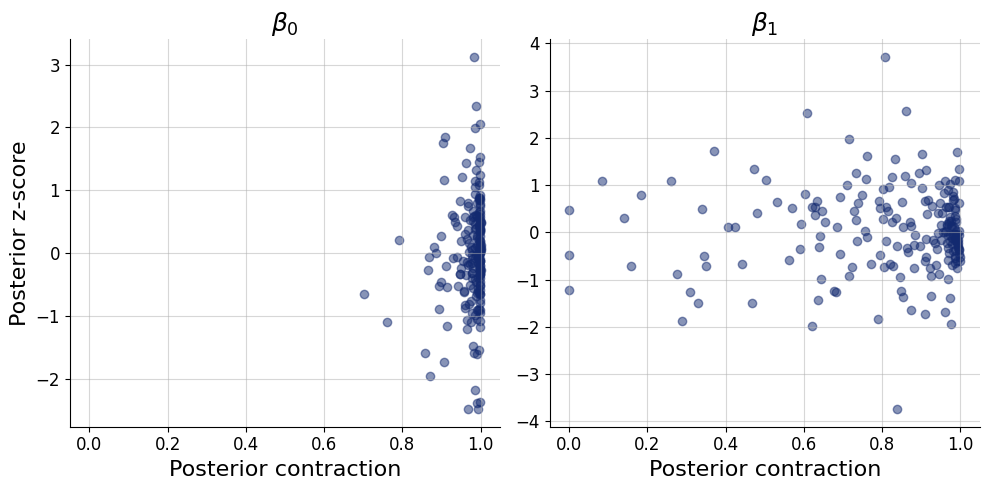

In [3]:
# Generate a batch of three training samples
sim_draws = simulator.sample(500)
print(sim_draws["N"])
print(sim_draws["beta"].shape)
print(sim_draws["sigma"].shape)
print(sim_draws["x"].shape)
print(sim_draws["y"].shape)

par_keys = ["beta", "sigma"]
par_names = [r"$\beta_0$", r"$\beta_1$", r"$\sigma$"]

f = bf.diagnostics.plots.pairs_samples(
    samples=sim_draws,
    variable_keys=par_keys,
    variable_names=par_names
)

adapter = (
    bf.Adapter()
    .broadcast("N", to="x")
    .as_set(["x", "y"])
    .constrain("sigma", lower=0)
    .sqrt("N")
    .convert_dtype("float64", "float32")
    .concatenate(["beta", "sigma"], into="inference_variables")
    .concatenate(["x", "y"], into="summary_variables")
    .rename("N", "inference_conditions")
)

processed_draws = adapter(sim_draws)
print(processed_draws["summary_variables"].shape)
print(processed_draws["inference_conditions"].shape)
print(processed_draws["inference_variables"].shape)

summary_network = bf.networks.SetTransformer(summary_dim=10)
inference_network = bf.networks.CouplingFlow()
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_network,
    summary_network=summary_network,
    standardize=["inference_variables", "summary_variables"]
)
history = workflow.fit_online(epochs=50, batch_size=64, num_batches_per_epoch=200)
f = bf.diagnostics.plots.loss(history)
# Set the number of posterior draws you want to get
num_samples = 1000

# Simulate validation data (unseen during training)
val_sims = simulator.sample(200)

# Obtain num_samples samples of the parameter posterior for every validation dataset
post_draws = workflow.sample(conditions=val_sims, num_samples=num_samples)

# post_draws is a dictionary of draws with one element per named parameters
post_draws.keys()
print(post_draws["beta"].shape)
post_draws["sigma"].min()
f = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=val_sims,
    dataset_id=0,
    variable_names=par_names,
)
f = bf.diagnostics.plots.recovery(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)
f = bf.diagnostics.plots.calibration_histogram(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)
f = bf.diagnostics.plots.calibration_ecdf(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names,
    difference=True,
    rank_type="distance"
)
f = bf.diagnostics.plots.z_score_contraction(
    estimates=post_draws, 
    targets=val_sims,
    variable_keys=["beta"],
    variable_names=par_names[0:2]
)



In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from memilio.simulation.abm import forward_pass 
import time

test = forward_pass(0.0001)
print(test)

start = time.time()

for i in range(100):
    test = forward_pass(0.08)
end = time.time()
print(end - start)

[[  0.  50.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1. 203.  51.  50.   0.   0.   0.   0.   0.   0.   0.]
 [  2. 109.   4. 203.  51.  50.   0.   0.   0.   0.   0.]
 [  3.  23.  16. 109.   4. 203.  51.  50.   0.   0.   0.]
 [  4.   7.   4.  23.  16. 109.   4. 203.  51.  50.   0.]
 [  5.   7.   9.   7.   4.  23.  16. 109.  54. 254.   0.]
 [  6.   3.   4.   7.   9.   7.   4.  23. 323. 110.   0.]
 [  7.   0.   1.   3.   4.   7.   9.   7. 431.  29.   0.]
 [  8.   1.   0.   0.   1.   3.   4.   7. 468.   8.   0.]
 [  9.   1.   1.   1.   0.   0.   1.   3. 479.   8.   0.]
 [ 10.   1.   0.   1.   1.   1.   0.   0. 485.   6.   0.]
 [ 11.   0.   5.   1.   0.   1.   1. 102. 390.   0.   0.]
 [ 12.   0.   0.   0.   5.   1.   0. 309. 184.   1.   0.]
 [ 13.   0.   0.   0.   0.   0.   5. 434.  60.   1.   0.]
 [ 14.   0.   0.   0.   0.   0.   0. 460.  39.   1.   0.]
 [ 15.   0.   0.   0.   0.   0.   0. 476.  24.   0.   0.]
 [ 16.   0.   0.   0.   0.   0.   0. 487.  13.   0.   0.]
 [ 17.   0.   